# 캘리포니아 주택가격 예측 모델 만들기

### matplotlib 설정

* matplotlib으로 그린 그림이 노트북 안에 포함되도록 설정.
* 생성한 그림을 저장.

### 경로 설정

In [1]:
import os
datapath = os.path.join("data", "handson-ml", "housing", "")

In [2]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴드
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join("images", "", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(datapath, fig_id + "." + fig_extension) # 책 코드 수정.
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 예제 2

캘리포니아의 인구조사 데이터를 사용해 캘리포니아의 주택 가격 모델을 만든다. 머신러닝의 전 과정을 익히는 것에 초점을 맞춘다.

## 데이터 다운로드
> 웹 브라우저를 이용해 `.tgz` 파일을 다운받고, 압축을 푼다. 함수 실행 시 자동으로 압축 풀리며, `.csv` 파일 생성된다.
* 책의 코드는 urllib을 six.moves에서 import했다.
* 어차피 python3니까 urllib 모듈 사용하면 된다.

In [3]:
# import module

import os
import tarfile
import urllib # 코드 수정 : python 3에서는 urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/" 
HOUSING_PATH = os.path.join("data", "handson-ml", "housing", "")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

# data load function

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
# download data
fetch_housing_data()

## 데이터 로드
* csv 파일을 read하는 것도 함수로 자동화한다.

In [5]:
# module import

import pandas as pd

# data loader

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [6]:
# load data
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## 데이터 확인
* 훈련 데이터를 훈련 세트와 테스트 세트로 분리하기 전, 간략하게 데이터를 살펴 본다.
* 이 단계가 지나면, **절대로** 테스트 세트를 들여다보지 않는다.
---
* 히스토그램을 그릴 때, 책에서는 매직 명령을 사용했는데 matplotlib 버전 1.5 이상이므로 자동으로 실행된다.

In [7]:
# 데이터에 대한 간략한 설명
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
# 범주형 변수 확인
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [9]:
# 숫자형 변수에 대한 요약 정보 확인
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


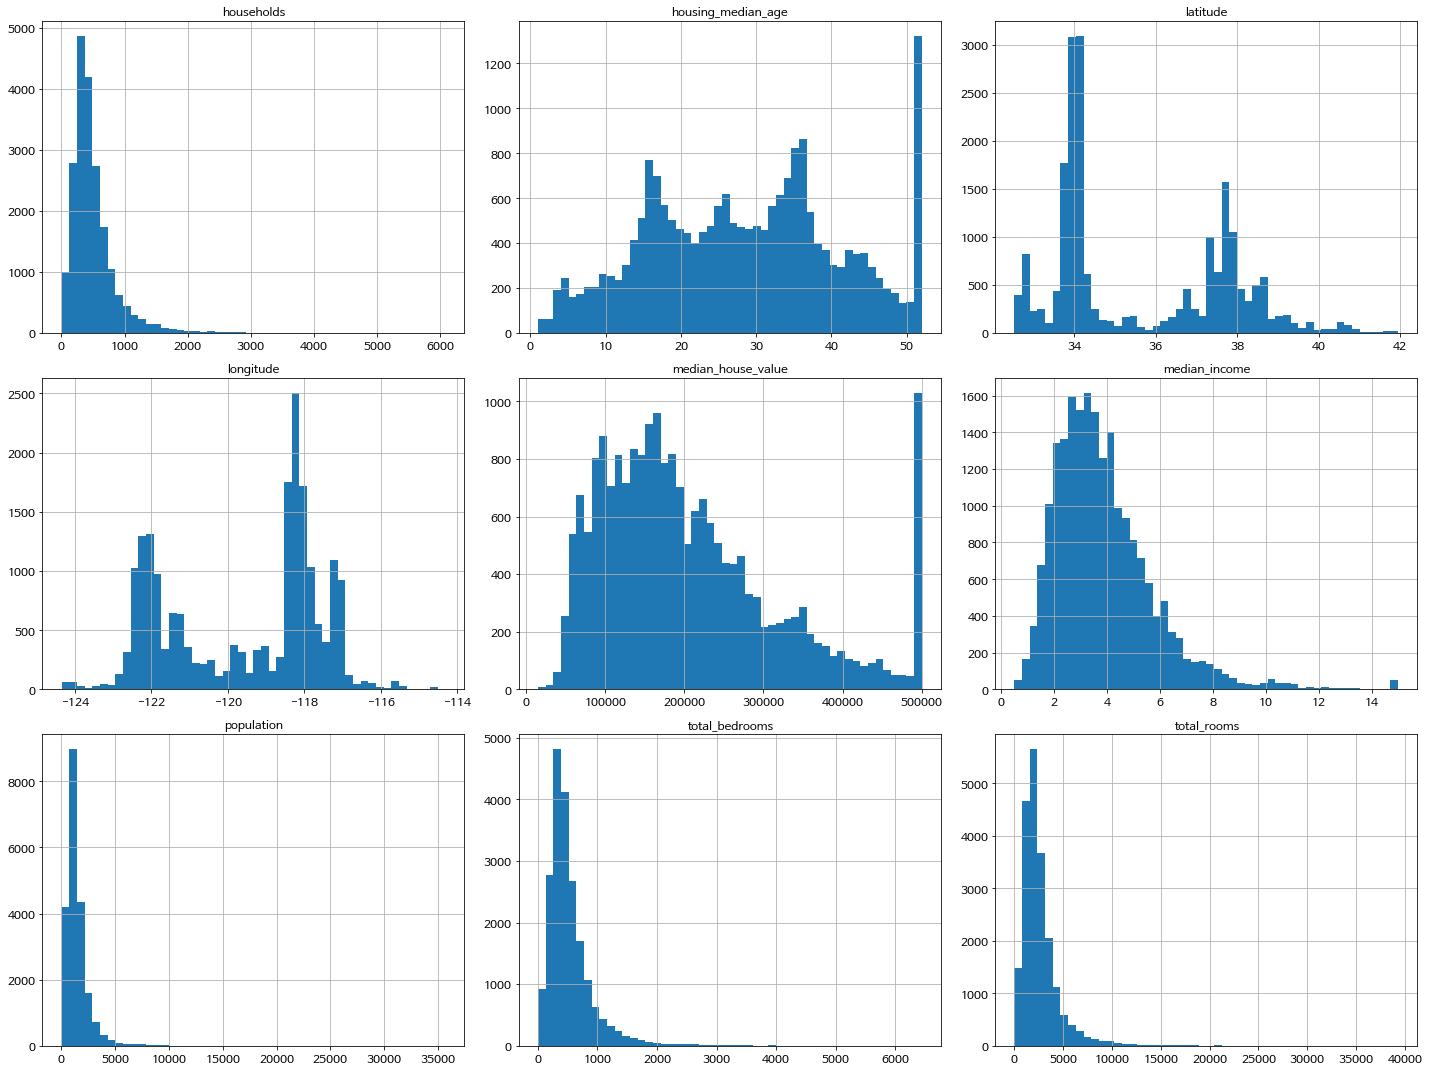

In [10]:
# 숫자형 변수에 대한 히스토그램 그리기

import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20, 15))
save_fig("attribute_histogram_plots")
plt.show()

## 테스트 세트 만들기
* 책에서는 다음의 세 가지 방식을 소개한다.
    * 무작위로 테스트 데이터 셋 만들기
        - 난수 발생기의 초깃값 지정 : 프로그램 실행할 때마다 다른 값이 생성되는 것을 방지.
        - 업데이트된 데이터셋을 사용할 수 없음.
    * 샘플의 식별자를 사용해 이전의 테스트 세트를 동일하게 유지하고, 새로운 데이터 셋에서 테스트 셋 만들기.
        - 해시값을 식별자로 사용.
        - 행의 인덱스를 식별자로 사용: 다음의 두 가지 조건을 만족해야 함.
            - 새 데이터는 데이터 셋의 끝에 추가되어야 하고,
            - 이전의 어떤 행도 삭제되지 않아야 함.
        - 고유 식별자를 만드는 안전한 특성을 사용하여 새로운 ID 생성. : 변하지 않는 값을 찾아서 사용해야 함.
    * 사이킷런의 `train_test_split` 함수 사용.
* 첫번째, 두번째 방법은 예시로 만든 코드이므로, 실습에서는 `train_test_split`함수를 이용한다. 위의 두 가지 방법은 github에 올려 놓았다.

---
### 사이킷런 train_test_split 함수
* `random_state` : 난수의 초깃값 지정.
* 행의 개수가 같은 여러 개의 데이터셋을 넘겨서 같은 index를 기반으로 나눌 수 있음.(`원자력 발전소 data`)
* 순수한 무작위 샘플링 : 샘플링 편향 생길 수 있음.
* 계층적 샘플링 : 전체를 계층이라는 동질적 그룹으로 나누고, 테스트 세트가 전체 집단을 대표하도록 각 계층에서 올바른 수의 샘플 추출.
            

### 계층적 샘플링
* (전문가의 조언을 받아) 집단의 특성을 예측하는 데 중요한 특성을 선택한다.
* 주의 사항
    * 계층별로 데이터셋에 충분한 샘플이 있어야 한다.
    * 너무 많은 계층으로 나누지 않는다.
* 과정
    * 계층 특성을 나타내는 카테고리 특성을 만든다.
    * 위의 카테고리 특성을 적절한 구간으로 나눈다.
    * `StratifiedShuffleSplit` 함수를 사용한다.
        - `.split()` 메서드 실행.
        - 인자 : split할 data, split할 data를 나타내는 특성.
    * 계층으로 나눈 뒤, 카테고리 특성은 삭제한다.

In [9]:
# 소득을 1.5로 나눠 카테고리 수 제한.
housing["income_cat"] = np.ceil(housing["median_income"]/1.5)

# np.where() 구문을 이용해 5 이상은 5로 반환.
housing["income_cat"].where(housing["income_cat"]<5, 5.0, inplace = True)

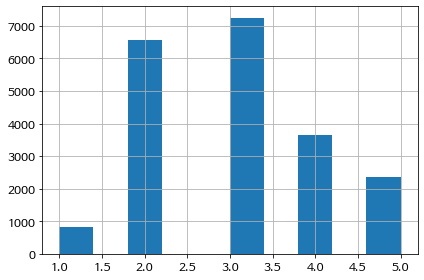

In [10]:
# 계층별 개수 확인
housing["income_cat"].value_counts()

# 개수 시각화 및 저장
housing["income_cat"].hist()
save_fig('income_category_hist')

In [11]:
# 게층별 비율 확인
housing["income_cat"].value_counts()/len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [12]:
# 계층별 샘플링 진행
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [13]:
# 나눈 test set에서의 계층별 비율 확인 : 거의 일치.
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [14]:
# 계층 나누기에 사용된 특성 삭제
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## 데이터 이해를 위한 탐색과 시각화
* 훈련 세트에 대해서만 진행한다.
* 훈련 세트를 손상시키지 않기 위해, 복사본을 만들어 진행한다.

In [15]:
# 복사본 만들기
housing_for_EDA = strat_train_set.copy()

### 지리적 데이터 시각화
> 지리 정보(위도, 경도)가 있을 때는, 지리 정보를 활용해 만들어 볼 수 있는 정보들을 산점도를 통해 시각화하는 것이 좋다.

* 주택 밀집도 : 모든 구역을 산점도로 만들어 시각화.
    * 투명도 파라미터를 통해 밀집된 지역을 알아볼 수 있다. 
    * 밀집된 지역일수록 덜 투명하게(=선명하게) 나타나기 때문이다.
* 주택 가격
    * `sharex=False` 옵션: x축의 값과 범례를 표시하지 못하는 버그 수정.
    * s: 마커의 크기 = 인구/100. 원의 반지름으로 표시됨.
    * c: 주택 가격 중간값.
    > 인구가 많을수록 원이 크게, 주택 가격이 높을수록 색이 빨간색에 가깝게 나타남.

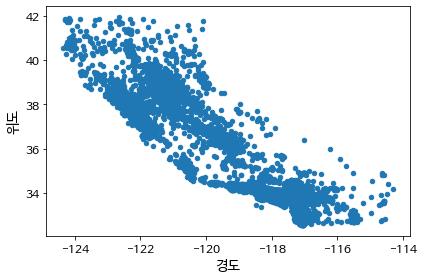

In [16]:
# 기본적 시각화
ax = housing_for_EDA.plot(kind="scatter", x="longitude", y="latitude")
ax.set(xlabel="경도", ylabel="위도")
save_fig("bad_visualization_plot")

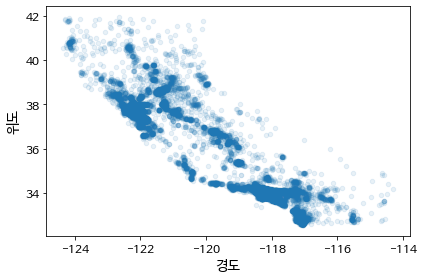

In [17]:
# 투명도 옵션을 통해 밀집된 지역을 알아보는 시각화
ax = housing_for_EDA.plot(kind="scatter", x="longitude", y="latitude",alpha=0.1)
ax.set(xlabel="경도", ylabel="위도")
save_fig("better_visualization_plot")

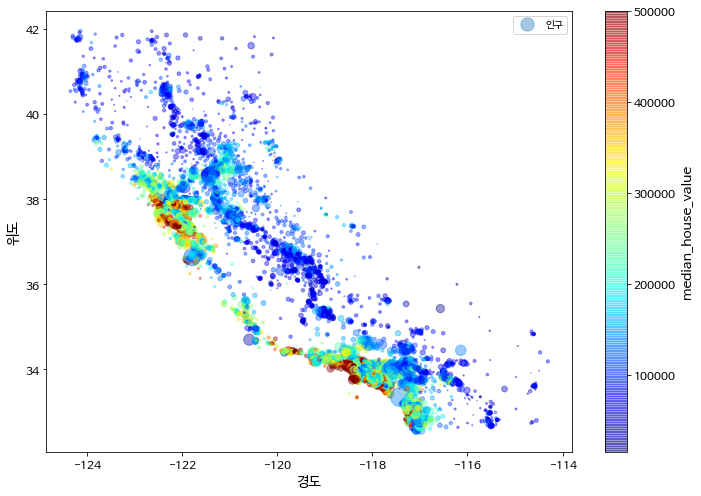

In [18]:
# 주택 가격 시각화
ax = housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
                 s=housing["population"]/100, label="인구", figsize=(10,7),
                 c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
                 sharex=False)
ax.set(xlabel="경도", ylabel="위도")
plt.legend()
save_fig("housing_prices_scatterplot")

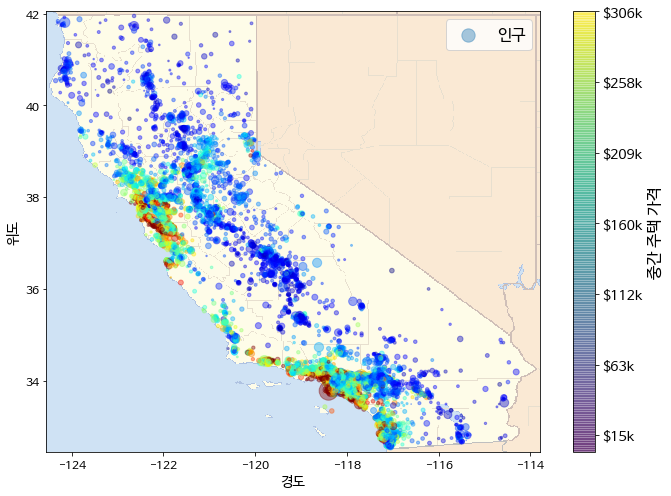

In [19]:
# 위에서 시각화한 것을 캘리포니아 위치 지도와 함께 나타내기

# extent : 캘리포니아 경도, 위도 설정
# 경도: 114°8'W ~ 124°24'W, 위도: 32°30'N ~ 42°N

# module import
import matplotlib.image as mpimg

# 캘리포니아 이미지 읽고, 그 위에 scatter 그리기. california 위도, 경도로 설정.
california_img = mpimg.imread(datapath + "california.png")
ax = housing_for_EDA.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                         s= housing['population']/100, label="인구",
                         c="median_house_value", cmap=plt.get_cmap("jet"),
                         colorbar=False, alpha=0.4)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.ylabel("위도", fontsize=14)
plt.xlabel("경도")

# prices colorbar 설정
prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk" %(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label("중간 주택 가격", fontsize=16)

# 범례(인구)의 글씨 크기 조정
plt.legend(fontsize=16)

save_fig("california_housing_prices_plot")
plt.show()

### 상관관계 조사
> 특성 간 상관관계를 조사하는 것이 좋다.
* 중요하다고 생각되는 특성과 다른 특성들 간 상관관계 조사.
* 수치형 특성들 모두에 대한 상관관계 산점도 그리기.
    * 나타내야 하는 특성이 많아 한 페이지에 그림이 나타날 수 없을 경우, 상관있어 보이는 특성들 위주로 상관관계 산점도 그리기.

In [20]:
# 모든 특성 간의 표준 상관계수 행렬 구하기
corr_matrix = housing_for_EDA.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


In [21]:
# 중간 주택가격과 다른 특성 간 상관관계
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

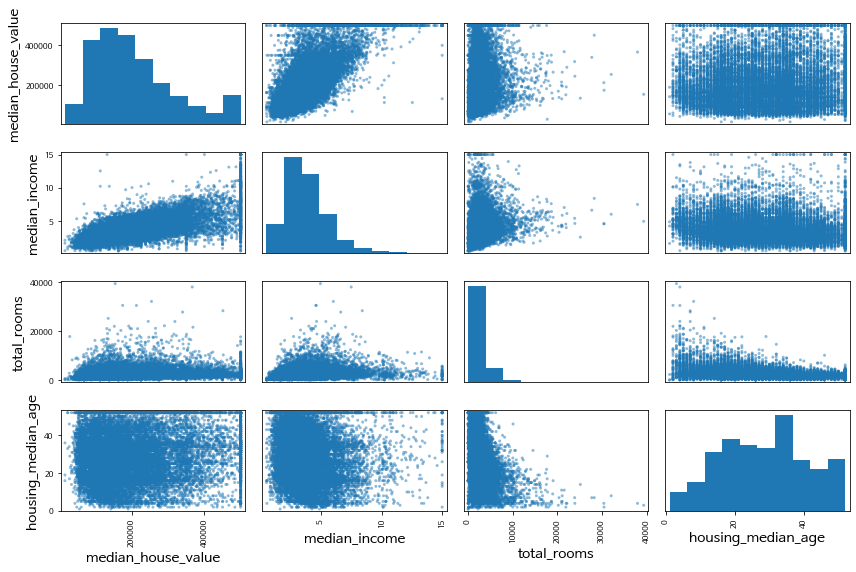

In [22]:
# 숫자형 특성 중 상관관계 높아 보이는 특성들 간 산점도를 그리기

from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing_for_EDA[attributes], figsize=(12,8))
save_fig("scatter_matrix_plot")

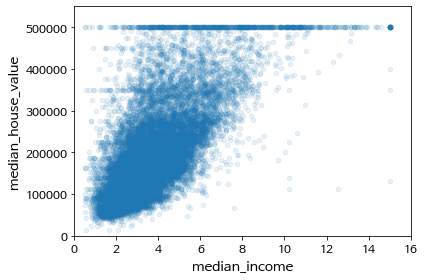

In [23]:
# median_income 확대
housing_for_EDA.plot(kind="scatter", x="median_income", y="median_house_value",
            alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

### 특성 조합으로 실험
> 여러 특성을 조합해 유용한 특성을 만들어낼 수 있다.
* 가구당 방 개수
* 한 방의 개수 당 침실 개수
* 가구 당 인원 수

In [24]:
# 새로운 특성 만들기
housing_for_EDA["rooms_per_household"]=housing_for_EDA["total_rooms"]/housing_for_EDA["households"]
housing_for_EDA["bedrooms_per_room"]=housing_for_EDA["total_bedrooms"]/housing_for_EDA["total_rooms"]
housing_for_EDA["population_per_household"]=housing_for_EDA["population"]/housing_for_EDA["households"]

In [25]:
# 새로운 특성이 추가되었으므로, 기초 통계량 다시 확인하기
housing_for_EDA.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724,5.440341,0.212878,3.096437
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830,2.611712,0.057379,11.584826
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000,4.442040,0.175304,2.431287
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000,5.232284,0.203031,2.817653
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000,6.056361,0.239831,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


In [26]:
# 상관관계 행렬 다시 그리기
corr_matrix = housing_for_EDA.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432,-0.028345,0.095603,-0.000410
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724,0.107621,-0.116884,0.005420
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110,-0.147186,0.136788,0.015031
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097,0.127519,-0.192606,-0.024810
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689,0.000377,0.086960,-0.028370
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920,-0.074692,0.037778,0.076225
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506,-0.083009,0.067162,-0.027416
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160,0.311563,-0.624674,0.021822
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000,0.146285,-0.259984,-0.021985
rooms_per_household,-0.028345,0.107621,-0.147186,0.127519,0.000377,-0.074692,-0.083009,0.311563,0.146285,1.000000,-0.398546,-0.005314


In [27]:
# 기존 특성에 비해 중간 주택 가격과 더 나은 상관관계를 갖는지 확인하기
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

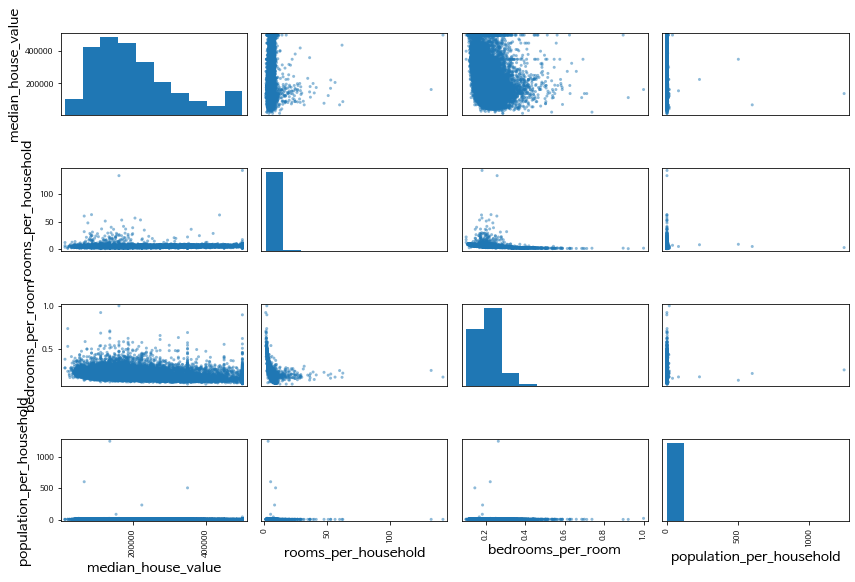

In [28]:
# 상관관계 산점도 다시 그려보기

attributes = ["median_house_value", "rooms_per_household", "bedrooms_per_room", "population_per_household"]
scatter_matrix(housing_for_EDA[attributes], figsize=(12,8))
save_fig("scatter_matrix_plot_new_features")

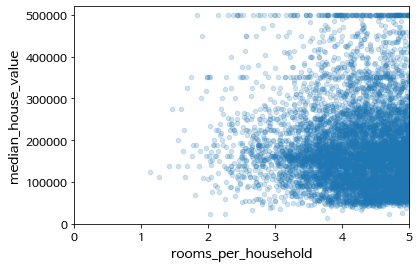

In [29]:
# rooms_per_household 선택해서 그려보기
housing_for_EDA.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
                    alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

## 머신러닝 알고리즘을 위한 데이터 준비
* 함수로 만들어 자동화 : 변환기.
* 과정
    * 훈련 세트 복사, 예측변수와 레이블 분리.
    * 수치형 데이터 정제 : 결측치, 이상치 등.
    * 텍스트 및 범주형 데이터 정체.
    * 특성 스케일링.
    * 변환기 만들기(위의 과정 자동화).

In [30]:
# 훈련 세트 복사, 예측 변수와 레이블 분리.
housing = strat_train_set.drop("median_house_value", axis=1, inplace=False)
housing_labels = strat_train_set["median_house_value"].copy()

### 데이터 정제(수치형 데이터)
> scaling하는 과정은 변환기 만들 때 한 번에 실습 진행.
> * `MinMaxScaler` : 0, 1 사이로 정규화. 상대적으로 이상치에 영향을 많이 받음.
> * `StandardScaler` : 평균이 0, 분산이 1인 정규분포로 만듦.
> **항상 (테스트 세트가 아닌) 훈련 세트에 대해서만 fit() 메서드를 적용. 이후 훈련 세트와 테스트 세트, 새로운 데이터에 대해 transfrom() 메서드를 적용해야 함**.

#### 결측치 확인 및 처리
* 해당 열 제거
* 전체 특성 삭제
* 특정 값으로 채우기 : 채운 값을 저장하고, test data set에서도 동일하게 채워야 함.
    * `.fillna()` 메서드
    * 사이킷런 `sklearn.impute.SimpleImputer` 클래스 : 책에는 `sklearn.preprocessing.Imputer`를 사용하지만, 이는 사이킷런 0.20 버전에서 사용 중지 경고가 발생하고 0.22 버전에서 삭제될 예정.


In [31]:
# 결측치 확인

# 결측치 있는 열 확인
housing.info() 

# 결측치 있는 행 확인
sample_incomplete_rows = housing[housing.isnull().any(axis=1)]
sample_incomplete_rows

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 9 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN
...,...,...,...,...,...,...,...,...,...
3376,-118.28,34.25,29.0,2559.0,NaN,1886.0,769.0,2.6036,<1H OCEAN
4691,-118.37,34.07,50.0,2519.0,NaN,1117.0,516.0,4.3667,<1H OCEAN
6052,-117.76,34.04,34.0,1914.0,NaN,1564.0,328.0,2.8347,INLAND
17198,-119.75,34.45,6.0,2864.0,NaN,1404.0,603.0,5.5073,NEAR OCEAN


#### SimpleImputer 활용해 결측치를 채운다.
* 어떤 값을 사용할 것인지 결정.
* 나중에 시스템이 서비스될 때, 새로운 데이터에 어떤 값이 누락될 지 알 수 없으므로 모든 수치형 특성에 imputer 적용.
* imputer로 훈련 세트 변환.

In [35]:
# Simple Imputer 사용

# module import
from sklearn.impute import SimpleImputer

# imputer 객체 생성
imputer = SimpleImputer(strategy="median")

# 중간값 특성은 수치형 특성에 대해서만 계산되므로, 텍스트 특성을 삭제한다.
housing_num = housing.drop("ocean_proximity", axis=1)
# 다른 방법 : housing_num = housing.select_dtypes(include=[np.number])

# imputer 객체에 fit 메서드 사용하여 변환 적용
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [36]:
# imputer에 적용된 통계치 확인하고 저장
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [34]:
# 수동으로 계산한 것과 동일한지 확인
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [42]:
# imputer가 적용한 방법 반환
imputer.strategy

'median'

In [39]:
# 훈련 세트 변환
X = imputer.transform(housing_num)
X

array([[-121.89  ,   37.29  ,   38.    , ...,  710.    ,  339.    ,
           2.7042],
       [-121.93  ,   37.05  ,   14.    , ...,  306.    ,  113.    ,
           6.4214],
       [-117.2   ,   32.77  ,   31.    , ...,  936.    ,  462.    ,
           2.8621],
       ...,
       [-116.4   ,   34.09  ,    9.    , ..., 2098.    ,  765.    ,
           3.2723],
       [-118.01  ,   33.82  ,   31.    , ..., 1356.    ,  356.    ,
           4.0625],
       [-122.45  ,   37.77  ,   52.    , ..., 1269.    ,  639.    ,
           3.575 ]])

In [40]:
# numpy array로 반환된 X를 dataframe으로 변환
housing_transformed = pd.DataFrame(X, columns=housing_num.columns,
                                  index=list(housing.index.values))

In [41]:
# 이전에 결측치로 채워져 있던 부분 검사하기
housing_transformed.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662
...,...,...,...,...,...,...,...,...
3376,-118.28,34.25,29.0,2559.0,433.0,1886.0,769.0,2.6036
4691,-118.37,34.07,50.0,2519.0,433.0,1117.0,516.0,4.3667
6052,-117.76,34.04,34.0,1914.0,433.0,1564.0,328.0,2.8347
17198,-119.75,34.45,6.0,2864.0,433.0,1404.0,603.0,5.5073


### 데이터 정제(문자형/범주형 데이터)
* 책에서 소개한 방법
    * `factorize()`, `OneHotEncoder`.
    * `CategoricalEncoder`
* 옮긴이가 소개한 방법 : `Oridinal Encoder`

---
책에서 소개한 방법 중 categorical encoder, 옮긴이가 소개한 original encoder를 사용해 실습을 진행합니다.

#### categorical encoder

* 하나 이상의 특성을 가진 2차원 배열을 입력해야 함.
* 그냥 사용하면 `NameError`가 나므로, class를 직접 소스에 추가하여 문제를 해결해야 한다.

In [55]:
# module import
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

# categorical encoder class 추가
class CategoricalEncoder(BaseEstimator, TransformerMixin):    
    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")
            
        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self
        
    def transform(self, X):        
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])
            
            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
            else:
                X_mask[:, i] = valid_mask
                X[:, i][~valid_mask] = self.categories_[i][0]
                
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [66]:
# categorical encoder 객체 생성
cat_encoder = CategoricalEncoder()

# 차원 변환
housing_cat_reshaped = housing_cat.values.reshape(-1,1)

# categorical encoder를 사용해 원핫벡터로 변환
housing_cat_onehot = cat_encoder.fit_transform(housing_cat_reshaped)

# 결과 확인
housing_cat_onehot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [67]:
# dense vector로 변환
housing_cat_onehot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [68]:
# 생성된 범주 확인
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

#### ordinalEncoder
* 입력 특성(X)을 위해 설계됨.
* 파이프라인과 잘 작동함.

In [71]:
# 범주형 변수 반환
housing_cat = housing[["ocean_proximity"]]
housing_cat

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
...,...
6563,INLAND
12053,INLAND
13908,INLAND
11159,<1H OCEAN


In [73]:
# module import
from sklearn.preprocessing import OrdinalEncoder

# ordinal encoder 객체 생성
ordinal_encoder = OrdinalEncoder()

# 변환
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

# 결과 확인
print(housing_cat_encoded[:10])

# 생성된 범주 확인
print(ordinal_encoder.categories_)

[[0.]
 [0.]
 [4.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]]
[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


### 나만의 변환기 생성
* 책에서 소개한 방법 : 각각의 변환기 생성 후 `FeatureUnion` 사용
    * `TransformerMixin` : 마지막 변환기에 fit_transfrom() 메서드 적용
    * `add_bedrooms_per_room=True` 옵션
        - 추측컨대, bedrooms_per_room feature의 상관관계 수치가 (-)로 나왔기 때문에, 기본 옵션은 `True`로 주되, 필요하지 않으면 `False`로 바꿀 수 있도록?
* 옮긴이가 소개한 방법

#### 책에서 소개한 방법으로 변환기 생성하기
* selector : 사이킷런은 DataFrame을 바로 사용하지 못하기 때문에, 수치형이나 범주형 특성을 선택하는 클래스를 만들어야 함.

* 수치형 데이터에 대한 변환 파이프라인
    * `selector` : 특성 선택.
    * `imputer` : 결측치를 바꾸는 변환기.
    * `CombinedAttributesAdder` : 새로운 특성을 생성하는 변환기.
    * `std_scaler` : 특성에 대해 standard scaling을 진행하는 변환기.    
* 문자열/범주형 데이터에 대한 변환 파이프라인
    * `selector` : 특성 선택.
    * `cat_encoder` : 범주형 특성으로 바꾸는 변환기
* 둘을 합친 파이프라인

In [81]:
# 수치형인지 문자형인지 선택하도록 하는 객체 생성을 위해 selector class 생성.

# module import
from sklearn.base import BaseEstimator, TransformerMixin

# selector class
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

##### 수치형 데이터에 대한 변환 파이프라인
* 순서대로 진행되어야 함에 유의한다.

In [76]:
# CombinedAttributesAdder

# module import
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_idx, bedrooms_idx, population_idx, household_idx = 3, 4, 5, 6

# 새로운 특성을 생성하는 변환기 객체 생성을 위해 CombinedAttributesAdder class 생성.
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None): # 변환할 y는 없고, 그냥 X에 대해서만 column 추가.
        return self
    def transform(self, X, y=None): # numpy array 반환
        rooms_per_household = X[:, rooms_idx] / X[:, household_idx]
        population_per_household = X[:, population_idx] / X[:, household_idx]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_idx] / X[:, rooms_idx]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

# class를 이용해 새로운 feature 생성 결과 확인
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [79]:
# dataFrame으로 변환
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"])

# 결과 확인
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


In [82]:
# 특성 스케일링을 위한 변환기
from sklearn.preprocessing import StandardScaler

In [83]:
# 결측치 처리 위한 변환기
from sklearn.impute import SimpleImputer

In [85]:
# 파이프라인
from sklearn.pipeline import Pipeline

num_attribs = list(housing_num)

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())    
])

##### 문자열/범주형 데이터에 대한 변환 파이프라인
* 순서대로 진행되어야 함에 유의한다.

In [86]:
# 원핫 인코딩을 위한 변환기 : categorical Encoder

In [91]:
# 파이프라인
from sklearn.pipeline import Pipeline

cat_attribs = ["ocean_proximity"]

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")), 
])

##### 전체 변환 파이프라인
* 순서대로 진행되어야 함에 유의한다.

In [92]:
# module import
from sklearn.pipeline import FeatureUnion

# FeatureUnion 진행
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

#### 변환기 실행
* 여기서는 이제 원본 훈련 데이터 떼어 놓은 것 사용.

In [93]:
housing_prepared = full_pipeline.fit_transform(housing)
print(housing_prepared.shape)
housing_prepared

(16512, 16)


array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

#### 옮긴이가 소개한 방법으로 변환기 생성하기
* `ColumnTransformer` 이용 : selector와 `FeatureUnion` 없이 전체 파이프라인 생성 가능.
    * cat : 범주형 특성 정의해서 onehot encoder에 넣어주면 바로 적용.

In [94]:
# module import
from sklearn.compose import ColumnTransformer

# 파이프라인 생성
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat",OneHotEncoder(categories="auto"), cat_attribs),
])

# 결과 확인
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

### 준비된 데이터
* housing_prepared

## 모델 선택과 훈련
* 훈련 세트에서 훈련 후, 평가.
* 교차 검증을 사용한 평가.
* 사용하는 모델
    * 선형회귀 모델

### 훈련 세트 훈련 후 평가

#### Linear Regression 모델
* 훈련
* MSE 측정

In [95]:
# module import
from sklearn.linear_model import LinearRegression

# 모델 객체 생성
lr_model = LinearRegression()

# 훈련
lr_model.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [98]:
# 훈련한 모델에 대해 전체 파이프라인 적용 및 실제 레이블과 비교

# 파이프라인을 적용하지 않은 원본 데이터
some_data = housing.iloc[:5]
some_labels = housing_labels[:5]

# 파이프라인 적용
some_data_prepared = full_pipeline.transform(some_data)
print(some_data_prepared)

# 예측
print("예측:", lr_model.predict(some_data_prepared))

# 실제 레이블과의 비교
print("레이블:", list(some_labels))

[[-1.15604281  0.77194962  0.74333089 -0.49323393 -0.44543821 -0.63621141
  -0.42069842 -0.61493744 -0.31205452 -0.08649871  0.15531753  1.
   0.          0.          0.          0.        ]
 [-1.17602483  0.6596948  -1.1653172  -0.90896655 -1.0369278  -0.99833135
  -1.02222705  1.33645936  0.21768338 -0.03353391 -0.83628902  1.
   0.          0.          0.          0.        ]
 [ 1.18684903 -1.34218285  0.18664186 -0.31365989 -0.15334458 -0.43363936
  -0.0933178  -0.5320456  -0.46531516 -0.09240499  0.4222004   0.
   0.          0.          0.          1.        ]
 [-0.01706767  0.31357576 -0.29052016 -0.36276217 -0.39675594  0.03604096
  -0.38343559 -1.04556555 -0.07966124  0.08973561 -0.19645314  0.
   1.          0.          0.          0.        ]
 [ 0.49247384 -0.65929936 -0.92673619  1.85619316  2.41221109  2.72415407
   2.57097492 -0.44143679 -0.35783383 -0.00419445  0.2699277   1.
   0.          0.          0.          0.        ]]
예측: [210644.60459286 317768.80697211 210956.

In [99]:
# MSE 측정

# module import
from sklearn.metrics import mean_squared_error

# 전체 데이터에 대한 예측값
housing_predictions = lr_model.predict(housing_prepared)
lr_mse = mean_squared_error(housing_labels, housing_predictions)
lr_rmse = np.sqrt(lr_mse)
print(lr_rmse)

68628.19819848923


#### Decision Tree 모델
* 훈련
* MSE 측정

In [101]:
# 훈련
from sklearn.tree import DecisionTreeRegressor

dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [102]:
# mse 측정 : 과적합!
housing_predictions = dt_model.predict(housing_prepared)

dt_mse = mean_squared_error(housing_labels, housing_predictions)
dt_rmse = np.sqrt(dt_mse)
dt_rmse

0.0

#### SVM(linear kernel) 모델
* 훈련
* MSE 측정

In [150]:
# module import
from sklearn.svm import SVR

# 모델 객체 생성
svm_model = SVR(kernel="linear")

# 훈련
svm_model.fit(housing_prepared, housing_labels)

# 예측
housing_predictions = svm_model.predict(housing_prepared)

# 점수
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111094.6308539982

### 교차검증을 사용한 평가
* 훈련 세트를 분할하여 매번 다른 폴드를 평가에 사용하고, 나머지 폴드들을 훈련에 사용.
* 사이킷런에서 교차검증은 효용함수를 활용하므로, MSE에 (-)를 붙임.
---
> 평가 결과, 결정트리 모델에서의 점수는 대략 71404 +- 2439 사이로, 선형회귀모델에 비해 좋지 않음.

In [105]:
# module import
from sklearn.model_selection import cross_val_score

# 교차검증 이용해 평가
scores = cross_val_score(dt_model, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)

# 효용함수에 -값을 취해줘야 함.
tree_rmse_scores = np.sqrt(-scores)

array([70194.33680785, 66855.16363941, 72432.58244769, 70758.73896782,
       71115.88230639, 75585.14172901, 70262.86139133, 70273.6325285 ,
       75366.87952553, 71231.65726027])

In [106]:
# 점수의 평균과 표준편차를 나타내는 함수
def display_scores(scores):
    print("점수:", scores)
    print("평균:", scores.mean())
    print("표준편차:", scores.std())
    
display_scores(tree_rmse_scores)

점수: [70194.33680785 66855.16363941 72432.58244769 70758.73896782
 71115.88230639 75585.14172901 70262.86139133 70273.6325285
 75366.87952553 71231.65726027]
평균: 71407.68766037929
표준편차: 2439.4345041191004


#### RandomForest 모델
* 앙상블 학습 : 특성을 무작위로 선택해 많은 결정트리를 만들고, 그 예측을 평균내는 방식.
* 책의 코드에서와 달리, n_estimators= 100으로 설정 : 책보다 좋게 나옴.
* 한 모델에 대해 검증한 후, cross_val 진행.
---
> 시도한 결과, 훈련 세트에 대한 점수가 검증 세트에 대한 점수보다 낮아 과적합된 것을 알 수 있음.

훈련 세트에 대해서만 검증

In [107]:
# module import
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=42, verbose=1)
rf_model.fit(housing_prepared, housing_labels)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   16.7s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=1, warm_start=False)

In [108]:
# 예측
housing_predictions = rf_model.predict(housing_prepared)

# 점수
rf_mse = mean_squared_error(housing_labels, housing_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_rmse

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


18603.515021376355

교차 검증을 통해 검증 세트에 대해 검증
* 50182로 기존에 비해 낮아졌지만, 여전히 훈련세트에 대해서 적용한 것보다는 낮다.

### _과적합이 있다!!!_

In [109]:
# module import
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(rf_model, housing_prepared, housing_labels,
                               scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   14.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   14.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   15.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

점수: [49519.80364233 47461.9115823  50029.02762854 52325.28068953
 49308.39426421 53446.37892622 48634.8036574  47585.73832311
 53490.10699751 50021.5852922 ]
평균: 50182.303100336096
표준편차: 2097.0810550985693


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   14.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


## 모델 세부 튜닝
* 그리드 탐색
* 랜덤 탐색
* 앙상블 : 7장에서 다룸.
* 최상의 모델과 오차 분석.
    * 특성 중요도를 분석해서 덜 중요한 특성을 제외.

### 그리드 탐색
* 탐색하고자 하는 하이퍼파라미터와, 시도할 값을 dict로 지정해 전달.
* 가능한 모든 하이퍼파라미터 조합에 대해 교차검증을 사용해 평가.

In [112]:
# module import
from sklearn.model_selection import GridSearchCV

# 하이퍼파라미터 조합
param_grid = [
    # 하이퍼파라미터  조합 = 15개, bootstrap True
    {'n_estimators': [100, 300, 500], 'max_features': [2,4,6,8,10]},
    # bootstrap은 False로 하고, 다시 조합을 시도한다.
    {'bootstrap': [False], 'n_estimators': [100, 500], 'max_features':[4,6,8]}
]

# 모델 객체 생성
rf_model = RandomForestRegressor(random_state=42, verbose=1)

# 10fold에서 훈련, 총 (15+6)*10=210번의 훈련이 일어난다.
grid_search = GridSearchCV(rf_model, param_grid, cv=10, scoring="neg_mean_squared_error",
                          return_train_score=True, n_jobs=-1, verbose=1)
grid_search.fit(housing_prepared, housing_labels)

Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed: 28.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   57.8s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=1, warm_start=False),
             iid='deprecated', n_job

In [113]:
# 최상의 파라미터 조합 찾기
grid_search.best_params_

{'bootstrap': False, 'max_features': 6, 'n_estimators': 500}

In [114]:
# 최적의 추정기에 접근
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=42, verbose=1, warm_start=False)

In [116]:
# 테스트한 하이퍼파라미터 조합의 점수 확인 : 10번 검증의 평균 점수.

cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

51841.57771064348 {'max_features': 2, 'n_estimators': 100}
51444.84300258079 {'max_features': 2, 'n_estimators': 300}
51294.629054149555 {'max_features': 2, 'n_estimators': 500}
49284.25422810582 {'max_features': 4, 'n_estimators': 100}
49255.75039438253 {'max_features': 4, 'n_estimators': 300}
49140.37606868918 {'max_features': 4, 'n_estimators': 500}
49026.77837500419 {'max_features': 6, 'n_estimators': 100}
48777.84491656384 {'max_features': 6, 'n_estimators': 300}
48670.01234578354 {'max_features': 6, 'n_estimators': 500}
48905.745928827164 {'max_features': 8, 'n_estimators': 100}
48807.1848860525 {'max_features': 8, 'n_estimators': 300}
48732.47609003308 {'max_features': 8, 'n_estimators': 500}
49337.28600425458 {'max_features': 10, 'n_estimators': 100}
49135.64372702414 {'max_features': 10, 'n_estimators': 300}
49050.33736639056 {'max_features': 10, 'n_estimators': 500}
48466.447611815 {'bootstrap': False, 'max_features': 4, 'n_estimators': 100}
48274.301053967734 {'bootstrap': F

In [117]:
# 결과를 dataframe으로 반환한다.
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,3.879926,0.050309,0.094048,0.009461,2,100,NaN,"{'max_features': 2, 'n_estimators': 100}",-2.562182e+09,-2.444942e+09,...,-3.710999e+08,-3.713681e+08,-3.752487e+08,-3.683466e+08,-3.786498e+08,-3.758435e+08,-3.747204e+08,-3.778880e+08,-3.755795e+08,4.181375e+06
1,11.715474,0.129255,0.272671,0.038835,2,300,NaN,"{'max_features': 2, 'n_estimators': 300}",-2.509195e+09,-2.405664e+09,...,-3.600806e+08,-3.603846e+08,-3.610178e+08,-3.581726e+08,-3.651463e+08,-3.621633e+08,-3.590268e+08,-3.650023e+08,-3.623825e+08,2.973159e+06
2,19.950655,0.826410,0.403223,0.040199,2,500,NaN,"{'max_features': 2, 'n_estimators': 500}",-2.484900e+09,-2.399465e+09,...,-3.561234e+08,-3.559096e+08,-3.578194e+08,-3.550597e+08,-3.607465e+08,-3.588667e+08,-3.558032e+08,-3.599516e+08,-3.584627e+08,2.576842e+06
3,6.602646,0.342412,0.099834,0.026762,4,100,NaN,"{'max_features': 4, 'n_estimators': 100}",-2.340351e+09,-2.160555e+09,...,-3.423205e+08,-3.398485e+08,-3.393076e+08,-3.355074e+08,-3.447863e+08,-3.412176e+08,-3.356886e+08,-3.422160e+08,-3.409312e+08,3.179459e+06
4,20.852643,0.837423,0.323236,0.179143,4,300,NaN,"{'max_features': 4, 'n_estimators': 300}",-2.334180e+09,-2.182112e+09,...,-3.323009e+08,-3.328072e+08,-3.313778e+08,-3.280012e+08,-3.354817e+08,-3.338066e+08,-3.295248e+08,-3.369834e+08,-3.329472e+08,2.611961e+06
5,31.432455,1.113027,0.368616,0.027328,4,500,NaN,"{'max_features': 4, 'n_estimators': 500}",-2.311342e+09,-2.188601e+09,...,-3.287149e+08,-3.282126e+08,-3.294136e+08,-3.255084e+08,-3.328371e+08,-3.311142e+08,-3.262187e+08,-3.320864e+08,-3.296837e+08,2.374547e+06
6,8.737039,0.544466,0.109208,0.081551,6,100,NaN,"{'max_features': 6, 'n_estimators': 100}",-2.336950e+09,-2.129720e+09,...,-3.360785e+08,-3.341829e+08,-3.381674e+08,-3.335302e+08,-3.381294e+08,-3.418988e+08,-3.341983e+08,-3.394835e+08,-3.378986e+08,3.144142e+06
7,26.290816,0.784356,0.251430,0.074182,6,300,NaN,"{'max_features': 6, 'n_estimators': 300}",-2.310114e+09,-2.122734e+09,...,-3.259797e+08,-3.226994e+08,-3.279692e+08,-3.225673e+08,-3.280401e+08,-3.295327e+08,-3.243026e+08,-3.291293e+08,-3.267807e+08,2.558970e+06
8,43.825419,0.904554,0.378487,0.042467,6,500,NaN,"{'max_features': 6, 'n_estimators': 500}",-2.307467e+09,-2.121661e+09,...,-3.232378e+08,-3.203426e+08,-3.246664e+08,-3.203028e+08,-3.261639e+08,-3.271752e+08,-3.213412e+08,-3.269538e+08,-3.242329e+08,2.599412e+06
9,10.902648,0.377082,0.114296,0.052277,8,100,NaN,"{'max_features': 8, 'n_estimators': 100}",-2.315054e+09,-2.098628e+09,...,-3.367925e+08,-3.372012e+08,-3.389421e+08,-3.320764e+08,-3.377403e+08,-3.353863e+08,-3.319405e+08,-3.408448e+08,-3.364496e+08,2.787947e+06


### 랜덤 탐색
* 하이퍼파라미터 탐색 공간이 커질 때 사용한다.
* 각 반복마다 하이퍼파라미터에 임의의 수를 대입하여 지정한 횟수만큼 평가한다.
* 장점
    * 랜덤 탐색의 횟수에 따라 하이퍼파라미터가 각기 다른 값을 탐색한다.
    * 단순히 반복 횟수를 조절함으로써 탐색에 투입할 컴퓨팅 자원을 제어할 수 있다.
* 랜덤 탐색이 어떻게 진행될지 분포 함수를 그려볼 수 있다.
---   
> 그리드 탐색보다 조금 나아짐. 

In [119]:
# module import
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    'n_estimators': randint(low=500, high=1000),
    'max_features': randint(low=1, high=8),
}

rf_model = RandomForestRegressor(random_state=42, verbose=1)
rnd_search = RandomizedSearchCV(rf_model, param_distributions=param_distribs,
                               n_iter=20, cv=10, scoring="neg_mean_squared_error",
                               random_state=42, n_jobs=-1,
                               verbose=1)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 36.8min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 38.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 885 out of 885 | elapsed:  1.1min finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                             

In [122]:
# 결과, 점수 확인
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("점수: ", np.sqrt(-mean_score), "조합: ", params)

점수:  48707.72790368459 조합:  {'max_features': 7, 'n_estimators': 935}
점수:  48697.25031053869 조합:  {'max_features': 5, 'n_estimators': 770}
점수:  49753.11774645276 조합:  {'max_features': 3, 'n_estimators': 571}
점수:  48795.78288497638 조합:  {'max_features': 5, 'n_estimators': 520}
점수:  48740.93761672433 조합:  {'max_features': 7, 'n_estimators': 621}
점수:  49734.138305064494 조합:  {'max_features': 3, 'n_estimators': 714}
점수:  49725.12339932124 조합:  {'max_features': 3, 'n_estimators': 958}
점수:  48761.698439824664 조합:  {'max_features': 5, 'n_estimators': 599}
점수:  49733.132345263686 조합:  {'max_features': 3, 'n_estimators': 649}
점수:  48707.13547076772 조합:  {'max_features': 5, 'n_estimators': 757}
점수:  49023.58541737869 조합:  {'max_features': 4, 'n_estimators': 913}
점수:  48592.34562968206 조합:  {'max_features': 6, 'n_estimators': 885}
점수:  49067.998439174866 조합:  {'max_features': 4, 'n_estimators': 776}
점수:  53692.534364183375 조합:  {'max_features': 1, 'n_estimators': 959}
점수:  51298.72545267386 조합:  {

In [124]:
rnd_search.best_params_

{'max_features': 6, 'n_estimators': 885}

### 최상의 모델과 오차 분석
* 시스템이 만들어 내는 오차를 보고, 왜 문제가 생기는지 이해하고 문제를 해결하는 방법을 찾아야 한다.
* 그 방식으로는 다음과 같은 것이 있다.
    * 추가 특성 포함.
    * 불필요한 특성 제거.
    * 이상치 제거.
* 그 중 책에서는 특성 중요도 분석을 통해 덜 중요한 특성을 제외하는 등의 방법을 소개하고 있다.

#### GridSearchCV를 이용한 특성 중요도 분석
* 최상의 모델을 분석함으로써 오차에 대한 통찰을 얻는다.
* `GridSearchCV`의 best_estimator에서 각 특성의 상대적인 중요도를 얻을 수 있다.
* 이름과 연결할 때, pipeline이 어떤 순서로 적용되었는지 생각하고, 순서대로 column명을 구해야 한다. 그렇지 않다면 엉뚱한 column을 삭제할 지도 모른다(..!)

In [126]:
# 특성 중요도 구하기
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([8.18933755e-02, 7.41085419e-02, 4.15869600e-02, 1.68629869e-02,
       1.56688213e-02, 1.66626275e-02, 1.54480754e-02, 3.18613185e-01,
       6.10416392e-02, 1.07506822e-01, 7.82108690e-02, 1.09714886e-02,
       1.52924099e-01, 7.55806329e-05, 3.58805218e-03, 4.83687661e-03])

In [134]:
# 특성 중요도와 이름 표시

# 추가한 특성
extra_attribs = ["rooms_per_household", "population_per_household", "bedrooms_per_rooms"]

# 범주형 특성 원핫벡터로 변환
cat_encoder = full_pipeline.named_transformers_["cat"] # 위에서 full_pipeline 다시 정의
cat_one_hot_attribs = list(cat_encoder.categories_[0])

# 속성 이름 구하기 : 순서대로 해야 한다.
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3186131845604475, 'median_income'),
 (0.1529240992233358, 'INLAND'),
 (0.10750682150428947, 'population_per_household'),
 (0.08189337553557918, 'longitude'),
 (0.07821086902044277, 'bedrooms_per_rooms'),
 (0.07410854186350849, 'latitude'),
 (0.06104163916293099, 'rooms_per_household'),
 (0.04158696002355169, 'housing_median_age'),
 (0.016862986888818682, 'total_rooms'),
 (0.016662627500703794, 'population'),
 (0.015668821344386276, 'total_bedrooms'),
 (0.015448075379864304, 'households'),
 (0.010971488574406295, '<1H OCEAN'),
 (0.004836876608209709, 'NEAR OCEAN'),
 (0.0035880521766143677, 'NEAR BAY'),
 (7.558063291075856e-05, 'ISLAND')]

### 최종 모델 만들기
* 테스트 세트로 시스템을 평가한다.
* 테스트 세트의 검증 점수에 대한 신뢰구간을 계산한다.
    * scipy 모듈 이용 : t점수, z점수 지원
    * 수동으로 계산

In [136]:
# 최적의 추정 모델 선정

final_model = grid_search.best_estimator_
final_model

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=42, verbose=1, warm_start=False)

In [137]:
# 테스트 세트 준비

# 변수와 타깃 속성 분리
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

# 테스트 세트 변환 : 파이프라인 적용
X_test_prepared = full_pipeline.transform(X_test)

# 예측 진행
final_predictions = final_model.predict(X_test_prepared)

# 최종 점수
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.6s finished


46059.78414446495

In [145]:
# 95% 신뢰구간 계산

# module import
from scipy import stats

# t점수 신뢰구간 계산 
confidence = 0.95
squared_errors = (final_predictions - y_test) **2
mean = squared_errors.mean()
m = len(squared_errors)

t_interval = stats.t.interval(confidence, m-1,
                              loc=np.mean(squared_errors),
                              scale=stats.sem(squared_errors))
t_score_interval = np.sqrt(t_interval)

# 수동으로 계산
tscore = stats.t.ppf((1+confidence)/2, df=m-1)
tmargin = tscore * squared_errors.std(ddof=1)/np.sqrt(m)
t_manual_interval = (np.sqrt(mean-tmargin), np.sqrt(mean+tmargin))

# 확인
print(t_score_interval)
print(t_manual_interval)

[44069.57239495 47967.49128103]
(44069.57239494981, 47967.491281029994)


In [146]:
# z점수 사용

zscore = stats.norm.ppf((1+confidence)/2)
zmargin = zscore * squared_errors.std(ddof=1)/np.sqrt(m)
z_manual_interval = (np.sqrt(mean-zmargin), np.sqrt(mean+zmargin))
print(z_manual_interval)

(44070.16925620956, 47966.94291487057)


### 전처리와 예측을 모두 포함한 일련의 파이프라인 형성

In [147]:
# 파이프라인 객체 생성
full_pipeline_with_RFmodel = Pipeline([
    ("preparation", full_pipeline),
    ("random_forest", RandomForestRegressor())
])

# 진행
full_pipeline_with_RFmodel.fit(housing, housing_labels)

# 예측
full_pipeline_with_RFmodel.predict(some_data)

array([264319.  , 334976.01, 223014.  ,  48892.  , 234851.  ])

## 모델 저장
* 실험한 모델을 모두 저장함으로써 필요할 때 쉽게 복원할 수 있다.
* 사이킷런의 `pickle` 패키지나 `joblib`을 사용해 모델을 저장한다.
* 이 때, 교차검증 점수와 실제 예측값, 하이퍼파라미터, 훈련된 모델 파라미터를 모두 저장해야 한다.
* 이후 여러 모델의 점수와, 모델이 만든 오차를 쉽게 비교할 수 있다.

In [148]:
# 모델 객체 저장
my_model_RF = full_pipeline_with_RFmodel

In [149]:
# module import
from sklearn.externals import joblib

# 모델 저장
joblib.dump(my_model_RF, "my_model_RF.pkl")

# 모델 로드
load_my_model_RF = joblib.load("my_model_RF.pkl")

C:\Users\user\Anaconda3\envs\cpu_env\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# 내용 흐름에 따라 실습 파일의 순서를 재구성했습니다. 
아래 셀들은 github에 예시로 올릴 코드들입니다.

## 1. 기타 샘플링 코드
### 1.1. 무작위 샘플링
### 1.2. 데이터셋 갱신 샘플링
* 해시값 활용.
    * zlib 모듈 활용 : hashlib 모듈보다 빠름.
    * hashlib 모듈 활용.
* 행의 인덱스 활용.
* 새롭게 형성한 인덱스 활용.

In [17]:
# 무작위 샘플링
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data)) # index 무작위로 섞음.
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

# 결과 확인
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


In [18]:
# 해시값 활용

# zlib 모듈
# python 2, 3 모두 지원.
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

# hashlib 모듈
import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

In [19]:
# index로 활용할 column을 지정.
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

# 행의 index 활용, 결과 확인
housing_with_id = housing.reset_index()   # 원래 housing 원본에는 index 열 없었음.
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
display(train_set.head(3))
display(test_set.head(3))

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5.0
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5.0
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5.0


,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3.0
5,5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY,3.0
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,3.0


In [20]:
# 새로운 id 열을 만들어서 index로 활용
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

# 결과 확인
display(train_set.head(2))
display(test_set.head(2))

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat,id
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5.0,-122192.12
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5.0,-122182.14


,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,2.0,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,3.0,-122222.15


## 2. 사이킷런 함수에서의 무작위 샘플링 예시 코드

In [21]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

# 결과 확인
display(train_set.head(3))
display(test_set.head(3))

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN,3.0
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN,3.0
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN,3.0


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND,2.0
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND,2.0
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY,3.0


## 3. 계층 샘플링과 무작위 샘플링의 오류율 비교
* 함수 정의 : income_cat이 차지하는 비중을 계층별로 나타내는 함수.
* 전체 계층별 비율, 무작위 샘플링 test set에서의 계층별 비율, 계층 샘플링 test set에서의 계층별 비율을 구하고, 오류율을 계산한다.
    * Overall : 전체 data set에서 income_cat 계층별 비율
    * random : 무작위 샘플링 test set.
    * strat : 계층 샘플링 test set.
* 오류율 : 동일하면 1이라고 보고, 얼마나 떨어지는지 퍼센티지를 나타냄.

In [22]:
# 계층별 비율 구하는 함수
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

# 무작위 샘플링
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

# 계층별 샘플링
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

# 비교할 data frame 생성
compare_props_df = pd.DataFrame({
    '전체' : income_cat_proportions(housing),
    '계층별' : income_cat_proportions(strat_test_set),
    '무작위' : income_cat_proportions(test_set)
}).sort_index()
compare_props_df["계층별 오류율"] = (100*(compare_props_df["계층별"]/compare_props_df["전체"]))-100
compare_props_df["무작위 오류율"] = (100*(compare_props_df["무작위"]/compare_props_df["전체"]))-100

# 결과 확인
display(compare_props_df)

,전체,계층별,무작위,계층별 오류율,무작위 오류율
1.0,0.039826,0.039729,0.040213,-0.243309,0.973236
2.0,0.318847,0.318798,0.324370,-0.015195,1.732260
3.0,0.350581,0.350533,0.358527,-0.013820,2.266446
4.0,0.176308,0.176357,0.167393,0.027480,-5.056334
5.0,0.114438,0.114583,0.109496,0.127011,-4.318374


# 5. 결측치 채우는 기타 옵션
* drop row
* drop column
* 채우기

In [73]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)]
display(sample_incomplete_rows)

# drop rows
sample_incomplete_rows_del_row = sample_incomplete_rows.dropna(subset=["total_bedrooms"])

# drop column
sample_incomplete_rows_del_col = sample_incomplete_rows.drop("total_bedrooms", axis=1)

# .fillna() 사용하여 채우기
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True)

# 결과 확인
display(sample_incomplete_rows_del_row)
display(sample_incomplete_rows_del_col)
display(sample_incomplete_rows)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
290,-122.16,37.77,47.0,1256.0,NaN,570.0,218.0,4.3750,161900.0,NEAR BAY,3.0
341,-122.17,37.75,38.0,992.0,NaN,732.0,259.0,1.6196,85100.0,NEAR BAY,2.0
538,-122.28,37.78,29.0,5154.0,NaN,3741.0,1273.0,2.5762,173400.0,NEAR BAY,2.0
563,-122.24,37.75,45.0,891.0,NaN,384.0,146.0,4.9489,247100.0,NEAR BAY,4.0
696,-122.10,37.69,41.0,746.0,NaN,387.0,161.0,3.9063,178400.0,NEAR BAY,3.0
...,...,...,...,...,...,...,...,...,...,...,...
20267,-119.19,34.20,18.0,3620.0,NaN,3171.0,779.0,3.3409,220500.0,NEAR OCEAN,3.0
20268,-119.18,34.19,19.0,2393.0,NaN,1938.0,762.0,1.6953,167400.0,NEAR OCEAN,2.0
20372,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,410700.0,<1H OCEAN,4.0
20460,-118.75,34.29,17.0,5512.0,NaN,2734.0,814.0,6.6073,258100.0,<1H OCEAN,5.0


C:\Users\user\Anaconda3\envs\cpu_env\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat


,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
290,-122.16,37.77,47.0,1256.0,570.0,218.0,4.3750,161900.0,NEAR BAY,3.0
341,-122.17,37.75,38.0,992.0,732.0,259.0,1.6196,85100.0,NEAR BAY,2.0
538,-122.28,37.78,29.0,5154.0,3741.0,1273.0,2.5762,173400.0,NEAR BAY,2.0
563,-122.24,37.75,45.0,891.0,384.0,146.0,4.9489,247100.0,NEAR BAY,4.0
696,-122.10,37.69,41.0,746.0,387.0,161.0,3.9063,178400.0,NEAR BAY,3.0
...,...,...,...,...,...,...,...,...,...,...
20267,-119.19,34.20,18.0,3620.0,3171.0,779.0,3.3409,220500.0,NEAR OCEAN,3.0
20268,-119.18,34.19,19.0,2393.0,1938.0,762.0,1.6953,167400.0,NEAR OCEAN,2.0
20372,-118.88,34.17,15.0,4260.0,1701.0,669.0,5.1033,410700.0,<1H OCEAN,4.0
20460,-118.75,34.29,17.0,5512.0,2734.0,814.0,6.6073,258100.0,<1H OCEAN,5.0


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
290,-122.16,37.77,47.0,1256.0,435.0,570.0,218.0,4.3750,161900.0,NEAR BAY,3.0
341,-122.17,37.75,38.0,992.0,435.0,732.0,259.0,1.6196,85100.0,NEAR BAY,2.0
538,-122.28,37.78,29.0,5154.0,435.0,3741.0,1273.0,2.5762,173400.0,NEAR BAY,2.0
563,-122.24,37.75,45.0,891.0,435.0,384.0,146.0,4.9489,247100.0,NEAR BAY,4.0
696,-122.10,37.69,41.0,746.0,435.0,387.0,161.0,3.9063,178400.0,NEAR BAY,3.0
...,...,...,...,...,...,...,...,...,...,...,...
20267,-119.19,34.20,18.0,3620.0,435.0,3171.0,779.0,3.3409,220500.0,NEAR OCEAN,3.0
20268,-119.18,34.19,19.0,2393.0,435.0,1938.0,762.0,1.6953,167400.0,NEAR OCEAN,2.0
20372,-118.88,34.17,15.0,4260.0,435.0,1701.0,669.0,5.1033,410700.0,<1H OCEAN,4.0
20460,-118.75,34.29,17.0,5512.0,435.0,2734.0,814.0,6.6073,258100.0,<1H OCEAN,5.0


# 6. 문자열/범주형 변수 처리
* `factorize()`와 `OneHotEncoder` 사용
    * 사이킷런 0.20 버전에서 OneHotEncoder의 동작 방식이 변경. 종전에는 0~최댓값 사이의 정수를 카테고리로 인식했지만, 앞으로는 정수나 문자열에 상관없이 고유한 값만을 카테고리로 인식. 경고 메세지를 피하기 위해 categories 매개변수를 auto로 설정.
    * OneHotEncoder는 기본적으로 희소 행렬을 반환하나, 필요하다면 밀집 행렬로 변환할 수 있음.
* `OneHotEncoder` 단독 사용
    * 기존 OneHotEncoder는 숫자를 원핫벡터로 바꿨다. 그러나 이제는 OneHotEncoder로 문자열로 된 범주형 변수를 변환할 수 있다.
    * dense 벡터로의 변환
        * `to.array()` 메서드를 사용하면 dense vector로 바꿀 수 있다.
        * encoding 매개변수로 sparse=Fasle 옵션을 줄 수도 있다.

In [43]:
# 문자열 변수 확인 : 문자열이지만 범주형 변수이다.
housing_cat = housing["ocean_proximity"]
housing_cat.head()

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
Name: ocean_proximity, dtype: object

In [45]:
# factorize() : 문자열 범주형 특성을 숫자 범주형 특성으로 변환
housing_cat_encoded, housing_categories = housing_cat.factorize()
print(housing_cat_encoded[:5])
print(housing_categories)

[0 0 1 2 0]
Index(['<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'NEAR BAY', 'ISLAND'], dtype='object')


In [46]:
housing_cat_encoded.reshape(-1,1)

array([[0],
       [0],
       [1],
       ...,
       [2],
       [0],
       [3]], dtype=int64)

In [47]:
# OneHotEncoder를 사용해 원핫벡터로 변경.
from sklearn.preprocessing import OneHotEncoder

# encoder 객체 생성
encoder = OneHotEncoder(categories="auto")

# 데이터에 맞추고 변환.
housing_cat_onehot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_onehot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [48]:
# dense matrix로 변환
housing_cat_onehot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [63]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(categories='auto')
housing_cat_reshaped = housing_cat.values.reshape(-1,1)
housing_cat_onehot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_onehot

# dense vector로 변환
housing_cat_onehot.toarray()

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [ ]:
# sparse=False 옵션 지정하여 dense vector로 변환
cat_encoder = OneHotEncoder(categories='auto', sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

# 기타

(674, 594, 3)


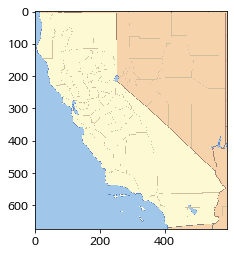

In [44]:
import matplotlib.image as mpimg

california = mpimg.imread(datapath + "california.png")
print(california.shape) # 컬러 이미지: 3차원
print(california) # 이미지를 np.array로 반환해서 읽어 옴.
plt.imshow(california) # 그냥 읽으면 가로가 경도가 안 되니까, extent 설정.